# JP Morgen Project

## Task 1 - Investigate and analyze price data



* AIM: pricing the natural gas storage contract
* OBJ1: extrapolate external data to increase granularity (Data preparation)
* OBJ2: analyse seasonality & annual trends
* OBJ3: price the contract using historical data to make future gas price prediction


**Background info:**
Commodity storage contract: an agreement (between warehouse owners and participants in the supply chain) to store an agreed quality of any physical commodity in a warehouse for specified amount of time.

**Key terms of such contracts:**
*  periodic storage fees, withdraws/injections limits.
*  Injection date: is the time when the commodity is purchased and stored
*  Withdraw date: the commodity is withdrawn from the storage.

**Data source:** monthly snapshot of prices which represents the market price of natural gas delivered at the end of each calendar month.
Data available for next 18mo + historical

**Task:** EDA historical data and an extrapolation for an extra year.
Estimate purchase price at any date in the past and extrapolate for one year into the future.

**Model input:** date

**Model output:** estimated price

**Model Used in this File** Prophet


In [102]:
!pip install prophet

In [208]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gc # Garbage Collector interface
import scipy as sp
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
import seaborn as sns

In [94]:
url = 'https://raw.githubusercontent.com/Hongyan-Wang/JP_Morgan_Project/main/Task1_Investigate_and_analyse_price_data/Nat_Gas.csv'
NatGas = pd.read_csv(url)
NatGas.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [ ]:
from datetime import datetime, date
NatGas['Dates'] = pd.to_datetime(NatGas['Dates'], format = '%m/%d/%y')
plt.figure(figsize=(10,6))
plt.plot(NatGas.Dates, NatGas.Prices)

In [69]:
# Extrac the time features from the rawdata

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df["Dates"], format='%m/%d/%y')
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear


    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(NatGas, label='Dates')
features_and_target = pd.concat([X, y, NatGas.Dates], axis=1)
features_and_target['prices'] = NatGas['Prices']
features_and_target.head()

<ipython-input-69-1e906fb9de2c>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Dates,Dates,prices
0,0,5,4,10,2020,305,31,44,2020-10-31,2020-10-31,10.1
1,0,0,4,11,2020,335,30,49,2020-11-30,2020-11-30,10.3
2,0,3,4,12,2020,366,31,53,2020-12-31,2020-12-31,11.0
3,0,6,1,1,2021,31,31,4,2021-01-31,2021-01-31,10.9
4,0,6,1,2,2021,59,28,8,2021-02-28,2021-02-28,10.9


# Exploratory data analysis (EDA)

## Visuallising the time series


*   Overall Plot
*   Seasonal Plot
*   Box Plot



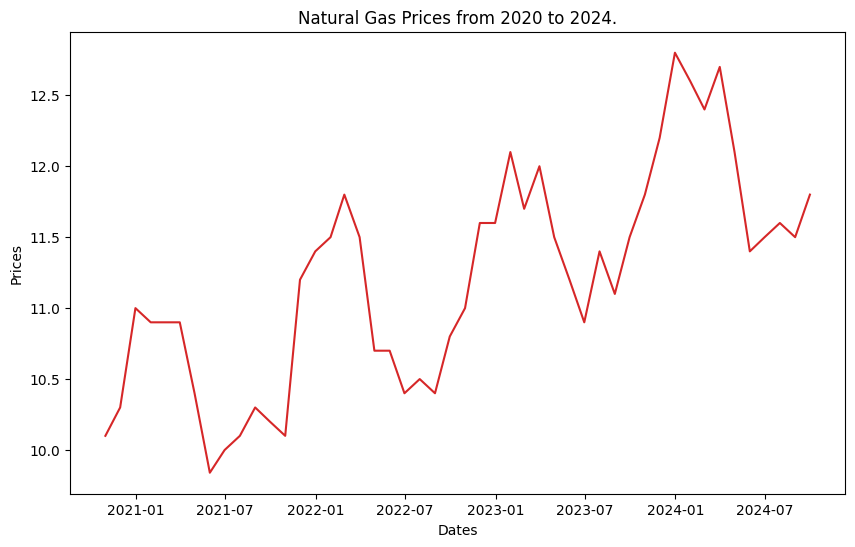

In [70]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Dates', ylabel='Prices', dpi=100):
    plt.figure(figsize=(10,6), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(NatGas, x=NatGas.Dates, y=NatGas.Prices, title='Natural Gas Prices from 2020 to 2024.')

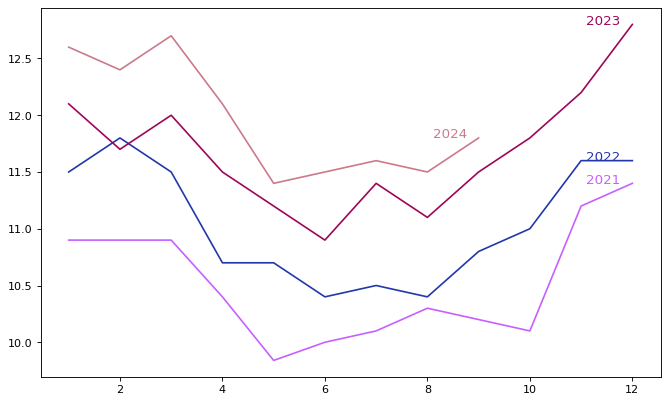

In [74]:
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)
years = features_and_target.year.unique()
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', 'prices', data=features_and_target.loc[features_and_target.year==y, :], color=mycolors[i], label=y)
        plt.text(features_and_target.loc[features_and_target.year==y, :].shape[0]-.9, features_and_target.loc[features_and_target.year==y, 'prices'][-1:].values[0], y, fontsize=12, color=mycolors[i])

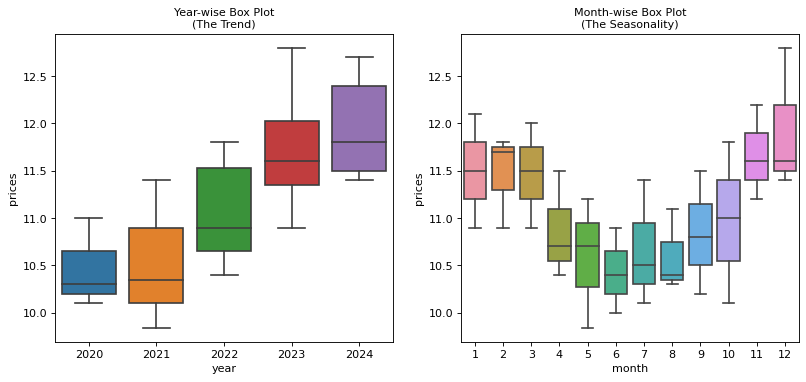

In [82]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(12,5), dpi= 80)
sns.boxplot(x='year', y='prices', data=features_and_target, ax=axes[0])
sns.boxplot(x='month', y='prices', data=features_and_target.loc[~features_and_target.year.isin([2020, 2024]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=10);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=10)
plt.show()

**Plotting the features to check the trend**

*  The highest 5- months prices
*  Average prices each month
*  Average prices each year
*  Plot out the yearly rolling mean on top of the original data


In [84]:
features_and_target.sort_values(by='prices', ascending=False).head(5)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Dates,Dates,prices
38,0,6,4,12,2023,365,31,52,2023-12-31,2023-12-31,12.8
41,0,6,1,3,2024,91,31,13,2024-03-31,2024-03-31,12.7
39,0,2,1,1,2024,31,31,5,2024-01-31,2024-01-31,12.6
40,0,3,1,2,2024,60,29,9,2024-02-29,2024-02-29,12.4
37,0,3,4,11,2023,334,30,48,2023-11-30,2023-11-30,12.2


<Axes: xlabel='month'>

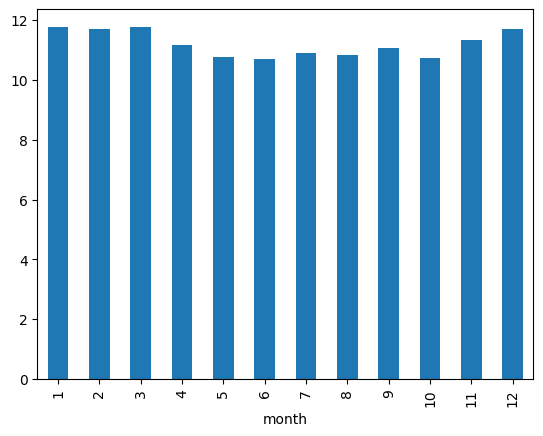

In [85]:
features_and_target.groupby(['month'])['prices'].mean().plot.bar()

<Axes: xlabel='year'>

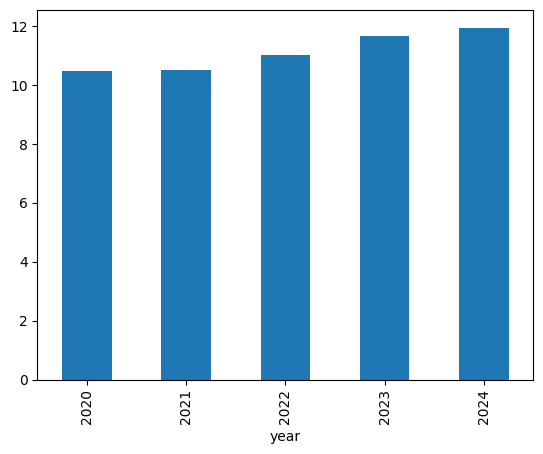

In [87]:
features_and_target.groupby(['year'])['prices'].mean().plot.bar()

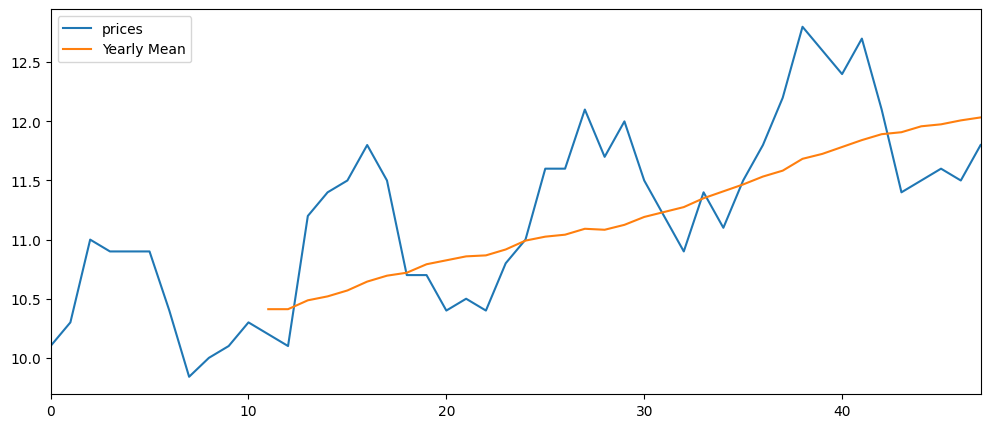

In [88]:
features_and_target['Yearly Mean'] = features_and_target['prices'].rolling(window=12).mean()
features_and_target[['prices','Yearly Mean']].plot(figsize=(12,5)).autoscale(axis='x',tight=True);

In [193]:
## split the original data set into two groups: train (75 %) + test (25 %)
url = 'https://raw.githubusercontent.com/Hongyan-Wang/JP_Morgan_Project/main/Task1_Investigate_and_analyse_price_data/Nat_Gas.csv'
df = pd.read_csv(url, parse_dates=['Dates'], index_col='Dates')
df.reset_index(inplace = True)
split_date = '2023-03-31'
train = df.loc[df.Dates <= split_date].copy()
test = df.loc[df.Dates > split_date].copy()
print(train.shape)
print(test.shape)

(30, 2)
(18, 2)


In [195]:
model = Prophet()
model.fit(train.rename(columns={'Dates':'ds',
                     'Prices':'y'}))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3v92oph/k4ewc4ah.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3v92oph/vhqps7f_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58210', 'data', 'file=/tmp/tmpq3v92oph/k4ewc4ah.json', 'init=/tmp/tmpq3v92oph/vhqps7f_.json', 'output', 'file=/tmp/tmpq3v92oph/prophet_model1oop99jf/prophet_model-20230914154340.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:43:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [196]:
test_fcst = model.predict(df=test.rename(columns={'Dates':'ds'}))
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-04-30,11.361876,10.690835,10.956281,11.361429,11.362324,-0.538580,-0.538580,-0.538580,-0.538580,-0.538580,-0.538580,0.0,0.0,0.0,10.823296
1,2023-05-31,11.394183,11.323715,11.595593,11.392655,11.395630,0.061476,0.061476,0.061476,0.061476,0.061476,0.061476,0.0,0.0,0.0,11.455659
2,2023-06-30,11.425449,10.623931,10.887881,11.422583,11.428236,-0.674433,-0.674433,-0.674433,-0.674433,-0.674433,-0.674433,0.0,0.0,0.0,10.751016
3,2023-07-31,11.457756,10.769632,11.032646,11.453509,11.462055,-0.562977,-0.562977,-0.562977,-0.562977,-0.562977,-0.562977,0.0,0.0,0.0,10.894779
4,2023-08-31,11.490064,10.383848,10.655500,11.484133,11.496422,-0.965079,-0.965079,-0.965079,-0.965079,-0.965079,-0.965079,0.0,0.0,0.0,10.524984


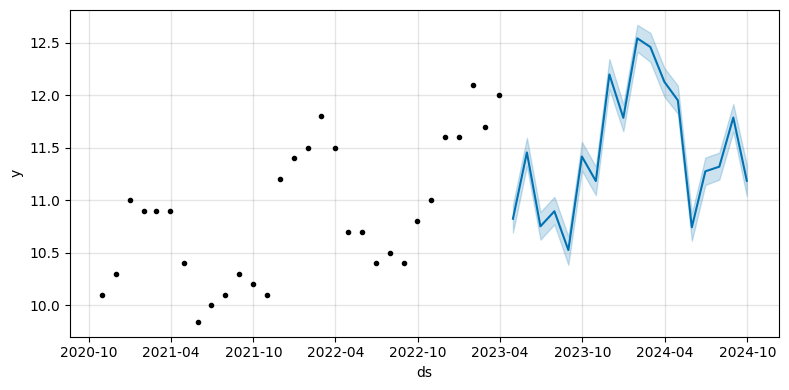

In [197]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(8)
fig = model.plot(test_fcst, ax=ax)
plt.show()

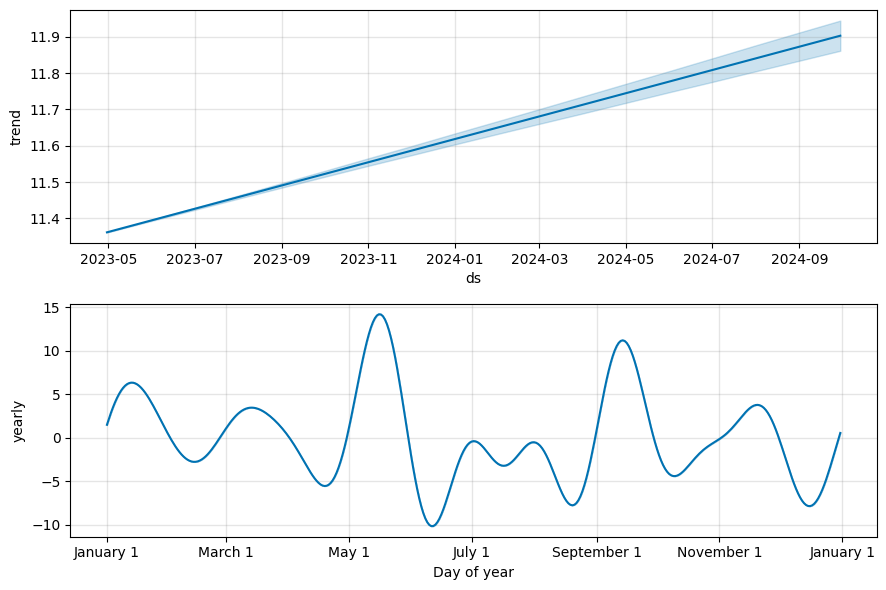

In [198]:
# Plot the components of the model
fig = model.plot_components(test_fcst)


# Compare Forecast to Actuals

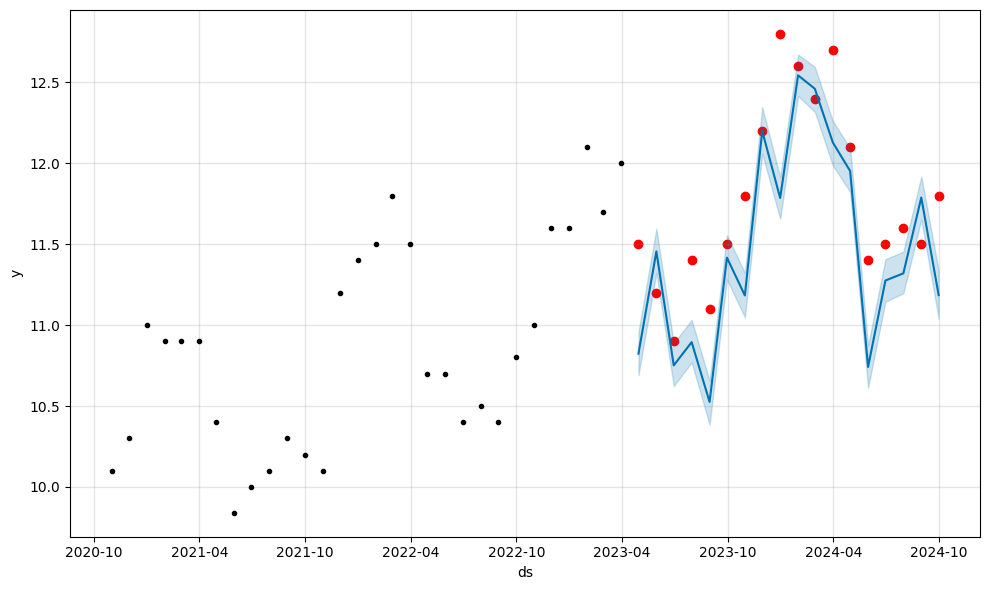

In [201]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(10)
ax.scatter(test.Dates, test['Prices'], color='r')
fig = model.plot(test_fcst, ax=ax)

# Look at the first month of predictions

# Error Metrics

In [210]:
mean_squared_error(y_true = test['Prices'],
                   y_pred = test_fcst['yhat'])


0.21800742046392177

In [211]:
mean_absolute_error(y_true=test['Prices'],
                   y_pred=test_fcst['yhat'])

0.37645171642300274

# Conclusions:

Using Prophet function, the **Mean Squred Errors** is 0.218;

**Mean Absolute Error** is 0.376

**Prophet** can give a relative good prediction of this historical data


# Next Step: Using Prophet to make predictions in the future

In [214]:
df = pd.read_csv(url,parse_dates =['Dates'],index_col='Dates')
df.reset_index(inplace = True)
df.rename(columns = {'Dates':'ds',
                     'Prices': 'y'}, inplace = True)

In [215]:
m= Prophet()
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3v92oph/m4ljchp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq3v92oph/zcv0apcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16088', 'data', 'file=/tmp/tmpq3v92oph/m4ljchp7.json', 'init=/tmp/tmpq3v92oph/zcv0apcx.json', 'output', 'file=/tmp/tmpq3v92oph/prophet_modelkaiun91y/prophet_model-20230914160012.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:00:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:00:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [218]:
future = m.make_future_dataframe(periods=12, freq='M')
future.tail()

,ds
55,2025-05-31
56,2025-06-30
57,2025-07-31
58,2025-08-31
59,2025-09-30


In [219]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
55,2025-05-31,11.853798,11.659280,12.044590
56,2025-06-30,11.848575,11.669397,12.037373
57,2025-07-31,11.983327,11.798753,12.170543
58,2025-08-31,11.949657,11.778247,12.133973
59,2025-09-30,12.153211,11.977088,12.349652


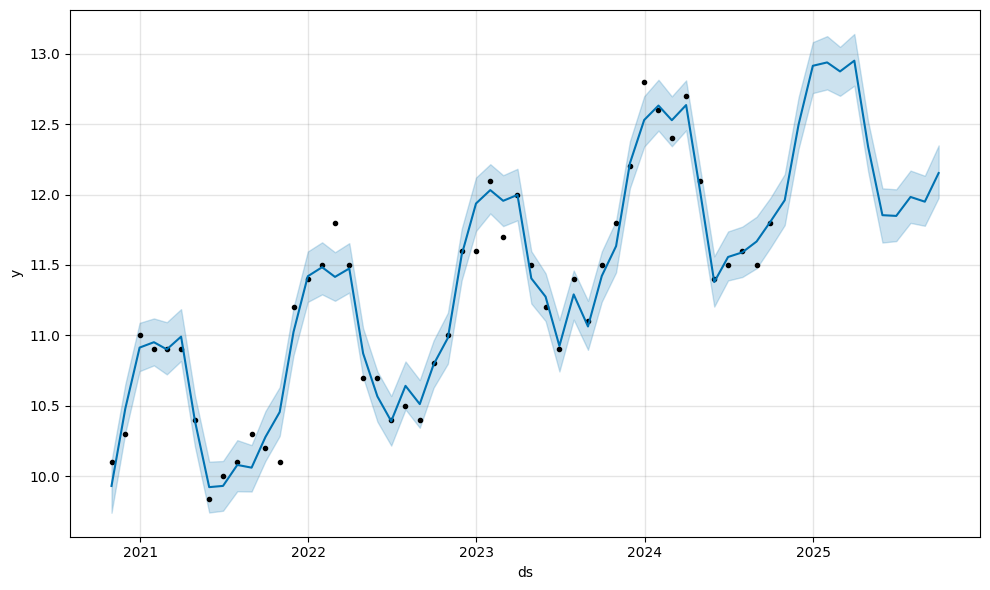

In [221]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(10)
fig1 = m.plot(forecast, ax=ax)

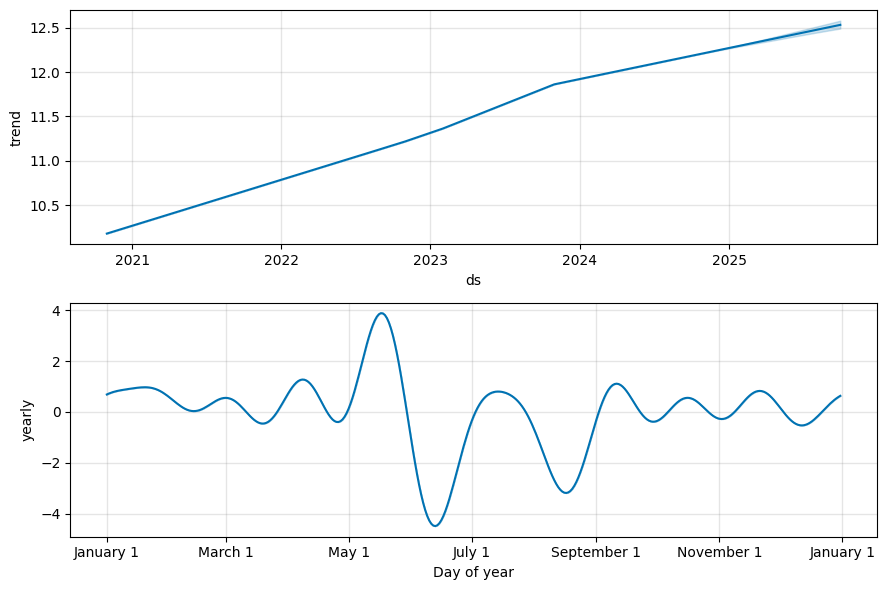

In [222]:
fig2 = m.plot_components(forecast)
